## 512 x 512 edition - Noise is modelled with a binning of the 1024 x 1024 images to 512 x 512.

# Fatpannel noise approximation

This notebook aims to analyze the characteristic of the noise in the experimental CXR from the fatpanel. This approximation can then be uset to generate synthetic training data.

Note the two used input images are of the LUNGMAN phantom, one image from the fatpanel, the other from a standard GE flatpanel.


## Steps
- [ ] Load the fatpanel data
- [ ] Crop the images to remove borders
- [ ] Blur image (Gaussian filter)
- [ ] High freq filter (blured v unblured) to find noise component 
- [ ] Sliding window analaysis of noise_std, blur_std, blur_mean, and "normalness"
- [ ] Map blur_mean to noise_std
- [ ] Fit polynomial to the data
  
## Evaluation
- [ ] Apply noise to GE image
- [ ] Make a visual comparison of the original and synthetic image

## Conculsions about the noise model

As there is some edge sharpening with the GE image, much like with most CXR images, some blurring is advisable. Gaussian with sigma 2-3 seems good.


The Sigma seems to not impact the polynomial fit too much:


### Example polynomial fit
#### Thsese settings:
```python
BORDER_CROP = (60, 50, 25, 35)  # (left, upper, right, lower)
SIGMA = 1.0  # Standard deviation for Gaussian blur

KERNEL_SIZE = 21 # Size for sliding window analysis

# Threshold parameters - For filtering out non-normal distributed windows for polyfit
SKEW_THRESHOLD = 0.2
KURT_THRESHOLD = 0.5  # difference from 3 (normal kurtosis)

CONTRAST_THRESH = 0.03 # Threshold for std_dev of blurred image to filter out areas spanning multiple structures/regions
```
#### Gives: 
Polynomial fit: std_noise = 0.0508 * mean_blur^2 + 0.0094 * mean_blur + 0.0055

## More improvements

Works amazing with the GE example. But it is maxed out at 196 which is just about 80% of the max value (255). 

Maybe all values should be mapped to a range of 0.01 - 0.8 before noise is applied. 
NOTE: This image should maybe be used as Ground Truth? Would prevent model from relying on clamping to achieve 0 values.

### The incresed noise further from the center is not captured
This is fine since lungs are the most important element. However this could be explained by the diffrence (ff - dark) which might make it easy to model (TODO! Check with Kian).


In [3]:
# Rinning images to 512 x 512
import os
import numpy as np
from PIL import Image

os.makedirs("input-512", exist_ok=True)

for f in os.listdir("input"):
    if f.lower().endswith(".png"):
        img = Image.open(f"input/{f}").convert("L")
        arr = np.array(img)
        if arr.shape != (1024, 1024):
            continue
        binned = arr.reshape(512, 2, 512, 2).mean((1, 3)).astype(np.uint8)
        Image.fromarray(binned, mode="L").save(f"input-512/{f}")

print("Binned images saved to input-512 directory.")

Binned images saved to input-512 directory.


C:\Users\Morris\AppData\Local\Temp\ipykernel_29776\2924133015.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(binned, mode="L").save(f"input-512/{f}")


In [4]:
# PARAMETERS
BORDER_CROP = (60, 50, 25, 35)  # (left, upper, right, lower)
SIGMA = 1.0  # Standard deviation for Gaussian blur

KERNEL_SIZE = 21 # Size for sliding window analysis
# !! Smaller than 1024 x 1024 version

# Threshold parameters - For filtering out non-normal distributed windows for polyfit
SKEW_THRESHOLD = 0.2
KURT_THRESHOLD = 0.5  # difference from 3 (normal kurtosis)

CONTRAST_THRESH = 0.02 # Threshold for std_dev of blurred image to filter out areas spanning multiple structures/regions


In [5]:
### Load and preprocess the fatpanel image

from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Load image
fatpanel_path = "input-512/fatpanel-binned-log.png"
fat_img = Image.open(fatpanel_path).convert("L")  # Grayscale

# Convert to tensor [0,1], shape (1, H, W) before cropping
to_tensor = transforms.ToTensor()
fat_tensor_full_size = to_tensor(fat_img)  # save full size tensor

# Crop image
width, height = fat_img.size
left, top, right, bottom = BORDER_CROP
fat_img_cropped = fat_img.crop((left, top, width - right, height - bottom))

# Convert cropped image to tensor
fat_tensor = to_tensor(fat_img_cropped)

# Show cropped image
plt.imshow(fat_tensor.squeeze(), cmap='gray')
plt.title("Cropped Fatpanel Image")
plt.axis('off')
plt.show()


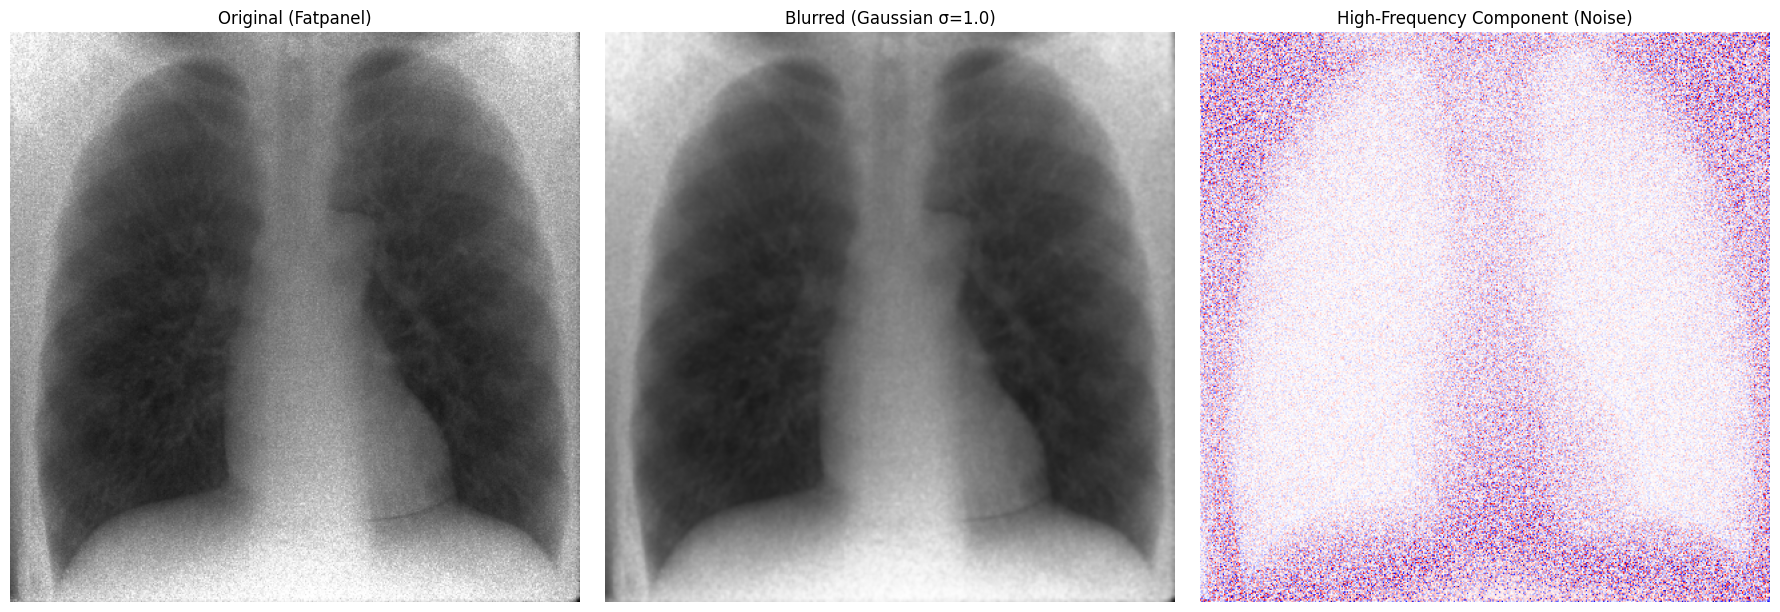

Noise stats: min=-0.2044, max=0.1853, mean=-0.0000


In [6]:
### Get noise component via high-frequency 

import scipy.ndimage
import numpy as np

# --- Blur with Gaussian filter ---
fat_np = fat_tensor.squeeze().cpu().numpy()  # shape: (H, W)
blurred_np = scipy.ndimage.gaussian_filter(fat_np, sigma=SIGMA)
blurred_tensor = torch.from_numpy(blurred_np).unsqueeze(0)  # shape: (1, H, W)

# --- High-frequency component (noise) ---
noise_tensor = fat_tensor - blurred_tensor  # retains +/- values

# --- Visualization ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(fat_tensor.squeeze(), cmap='gray', vmin=0, vmax=1)
axs[0].set_title("Original (Fatpanel)")
axs[0].axis("off")

axs[1].imshow(blurred_tensor.squeeze(), cmap='gray', vmin=0, vmax=1)
axs[1].set_title(f"Blurred (Gaussian σ={SIGMA})")
axs[1].axis("off")

# Use diverging colormap for zero-centered visualization
noise_np = noise_tensor.squeeze().cpu().numpy()
vmax = np.max(np.abs(noise_np))  # symmetric range for colormap
axs[2].imshow(noise_np, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[2].set_title("High-Frequency Component (Noise)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

# Print stats
print(f"Noise stats: min={noise_tensor.min():.4f}, max={noise_tensor.max():.4f}, mean={noise_tensor.mean():.4f}")


Pixels within normality thresholds: 91039 / 182329 (49.93%)
Done. All computed maps have shape: torch.Size([427, 427])


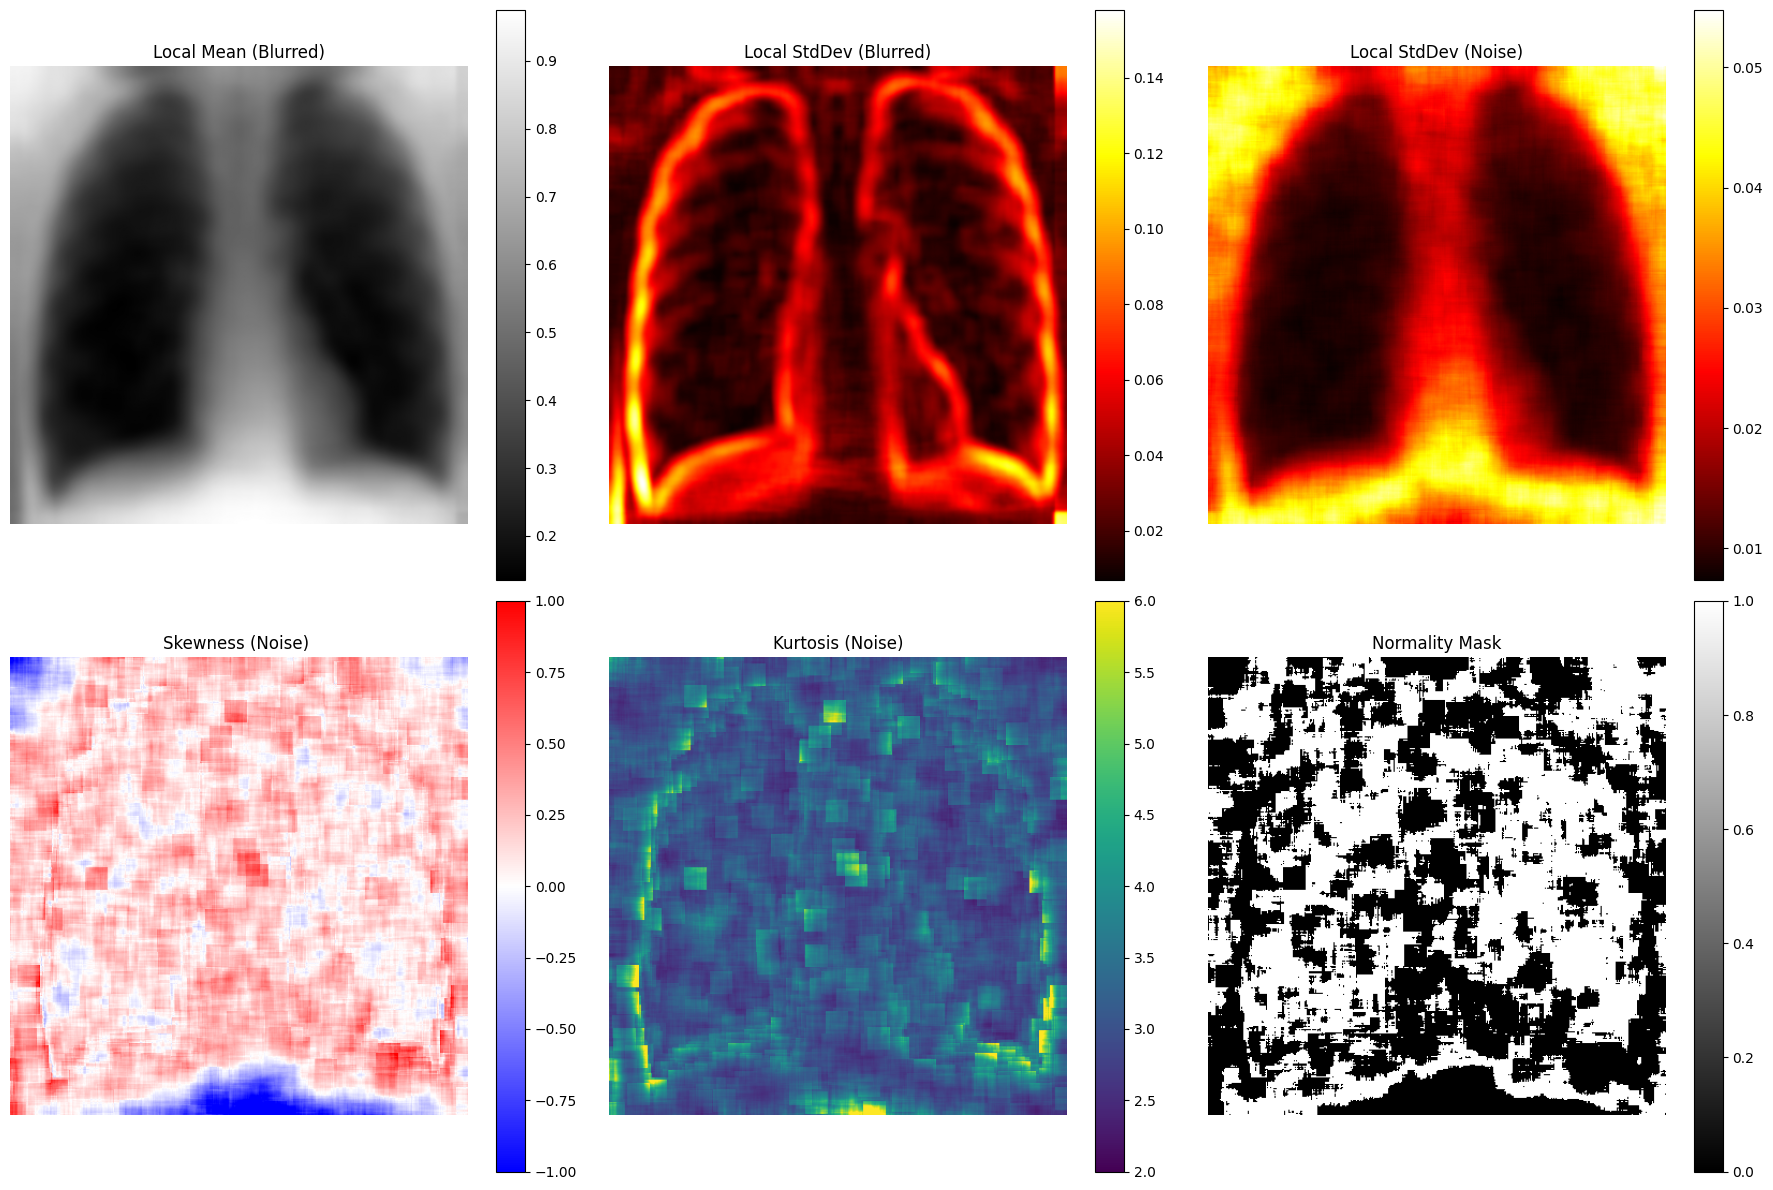

In [7]:
### Crossreference the blurred image with the noise component
# This is done locally using a sliding window approach to compute local statistics

import torch.nn.functional as F

PADDING = KERNEL_SIZE // 2

# Assume: blurred_tensor, noise_tensor are (1, H, W)
# Add batch dim for unfolding
blurred = blurred_tensor.unsqueeze(0)  # shape (1, 1, H, W)
noise = noise_tensor.unsqueeze(0)      # shape (1, 1, H, W)

# --- Reflective padding ---
blurred_padded = F.pad(blurred, (PADDING, PADDING, PADDING, PADDING), mode='reflect')
noise_padded = F.pad(noise, (PADDING, PADDING, PADDING, PADDING), mode='reflect')

# --- Unfold patches ---
blur_patches = F.unfold(blurred_padded, kernel_size=KERNEL_SIZE, padding=0)  # No padding here because we padded manually
noise_patches = F.unfold(noise_padded, kernel_size=KERNEL_SIZE, padding=0)

# Reshape to (1, 1, K*K, H, W)
_, _, H, W = blurred.shape
K2 = KERNEL_SIZE ** 2
blur_patches = blur_patches.view(1, 1, K2, H, W)
noise_patches = noise_patches.view(1, 1, K2, H, W)

# --- Compute local stats ---
mean_blur = blur_patches.mean(dim=2).squeeze()
std_blur = blur_patches.std(dim=2).squeeze()
std_noise = noise_patches.std(dim=2).squeeze()

# Skewness and kurtosis (centered)
centered = noise_patches - noise_patches.mean(dim=2, keepdim=True)
std = noise_patches.std(dim=2, keepdim=True) + 1e-6  # avoid div by zero
z = centered / std

skew = (z ** 3).mean(dim=2).squeeze()
kurt = (z ** 4).mean(dim=2).squeeze()

# Compute mask where skew and kurtosis are within thresholds
normal_mask = ((skew.abs() < SKEW_THRESHOLD) & ((kurt - 3).abs() < KURT_THRESHOLD))

# Print some stats
total_pixels = normal_mask.numel()
normal_pixels = normal_mask.sum().item()
percent_normal = 100 * normal_pixels / total_pixels

print(f"Pixels within normality thresholds: {normal_pixels} / {total_pixels} ({percent_normal:.2f}%)")
print(f"Done. All computed maps have shape: {mean_blur.shape}")

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Mean blurred image
im0 = axs[0, 0].imshow(mean_blur.cpu(), cmap='gray')
axs[0, 0].set_title('Local Mean (Blurred)')
axs[0, 0].axis('off')
fig.colorbar(im0, ax=axs[0, 0])

# Std dev blurred image
im1 = axs[0, 1].imshow(std_blur.cpu(), cmap='hot')
axs[0, 1].set_title('Local StdDev (Blurred)')
axs[0, 1].axis('off')
fig.colorbar(im1, ax=axs[0, 1])

# Std dev noise
im2 = axs[0, 2].imshow(std_noise.cpu(), cmap='hot')
axs[0, 2].set_title('Local StdDev (Noise)')
axs[0, 2].axis('off')
fig.colorbar(im2, ax=axs[0, 2])

# Skewness noise
im3 = axs[1, 0].imshow(skew.cpu(), cmap='bwr', vmin=-1, vmax=1)
axs[1, 0].set_title('Skewness (Noise) ')
axs[1, 0].axis('off')
fig.colorbar(im3, ax=axs[1, 0])

# Kurtosis noise
im4 = axs[1, 1].imshow(kurt.cpu(), cmap='viridis', vmin=2, vmax=6)
axs[1, 1].set_title('Kurtosis (Noise)')
axs[1, 1].axis('off')
fig.colorbar(im4, ax=axs[1, 1])

# Normality mask
normal_mask_np = normal_mask.cpu().numpy()
im5 = axs[1, 2].imshow(normal_mask_np, cmap='gray')
axs[1, 2].set_title('Normality Mask')
axs[1, 2].axis('off')
fig.colorbar(im5, ax=axs[1, 2])

plt.tight_layout()
plt.show()

Polynomial fit: std_noise = 0.0508 * mean_blur^2 + 0.0094 * mean_blur + 0.0055


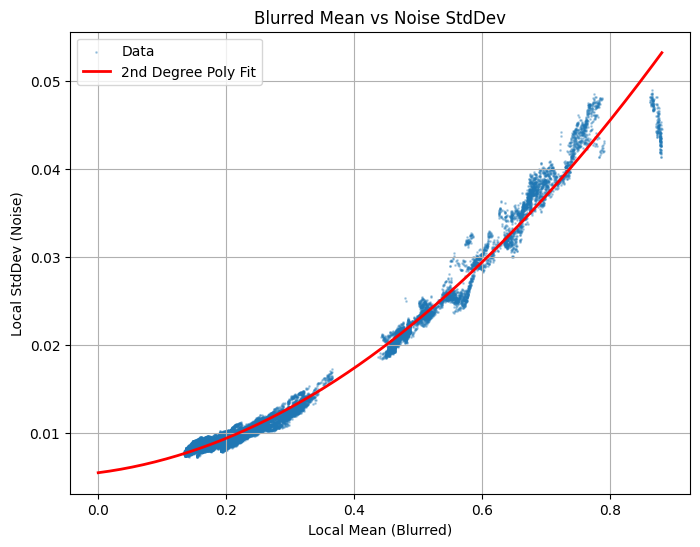

In [8]:
## Filter to find windows with clear and resonaable normal distributions and fit a polynomial to predict noise std dev from pixel values

import numpy as np
import matplotlib.pyplot as plt

# Flatten tensors
mean_blur_flat = mean_blur.flatten().cpu().numpy()
std_noise_flat = std_noise.flatten().cpu().numpy()


std_blur_flat = std_blur.flatten().cpu().numpy()
contrast_mask = std_blur_flat < CONTRAST_THRESH

normal_mask_flat = normal_mask.flatten().cpu().numpy()

x = mean_blur_flat[contrast_mask & normal_mask_flat]
y = std_noise_flat[contrast_mask & normal_mask_flat]


# Fit 2nd degree polynomial: y = a*x^2 + b*x + c
coeffs = np.polyfit(x, y, deg=2)
a, b, c = coeffs
print(f"Polynomial fit: std_noise = {a:.4f} * mean_blur^2 + {b:.4f} * mean_blur + {c:.4f}")

# Plot scatter and fit curve
plt.figure(figsize=(8,6))
plt.scatter(x, y, s=1, alpha=0.3, label='Data')
x_fit = np.linspace(0, x.max(), 200)
y_fit = a * x_fit**2 + b * x_fit + c
plt.plot(x_fit, y_fit, color='red', label='2nd Degree Poly Fit', linewidth=2)
plt.xlabel('Local Mean (Blurred)')
plt.ylabel('Local StdDev (Noise)')
plt.title('Blurred Mean vs Noise StdDev')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
### Module for polynomial noise std dev

import torch
import torch.nn as nn

class PolynomialNoiseStd(nn.Module):
    def __init__(self, a, b, c):
        super().__init__()
        # Register coefficients as buffers (constants)
        self.register_buffer('a', torch.tensor(a, dtype=torch.float32))
        self.register_buffer('b', torch.tensor(b, dtype=torch.float32))
        self.register_buffer('c', torch.tensor(c, dtype=torch.float32))

    def forward(self, x):
        # x is the blurred mean tensor
        return self.a * x ** 2 + self.b * x + self.c
    
# Polynomial noise from found coefficients
POLY_NOISE_STD = PolynomialNoiseStd(a, b, c)


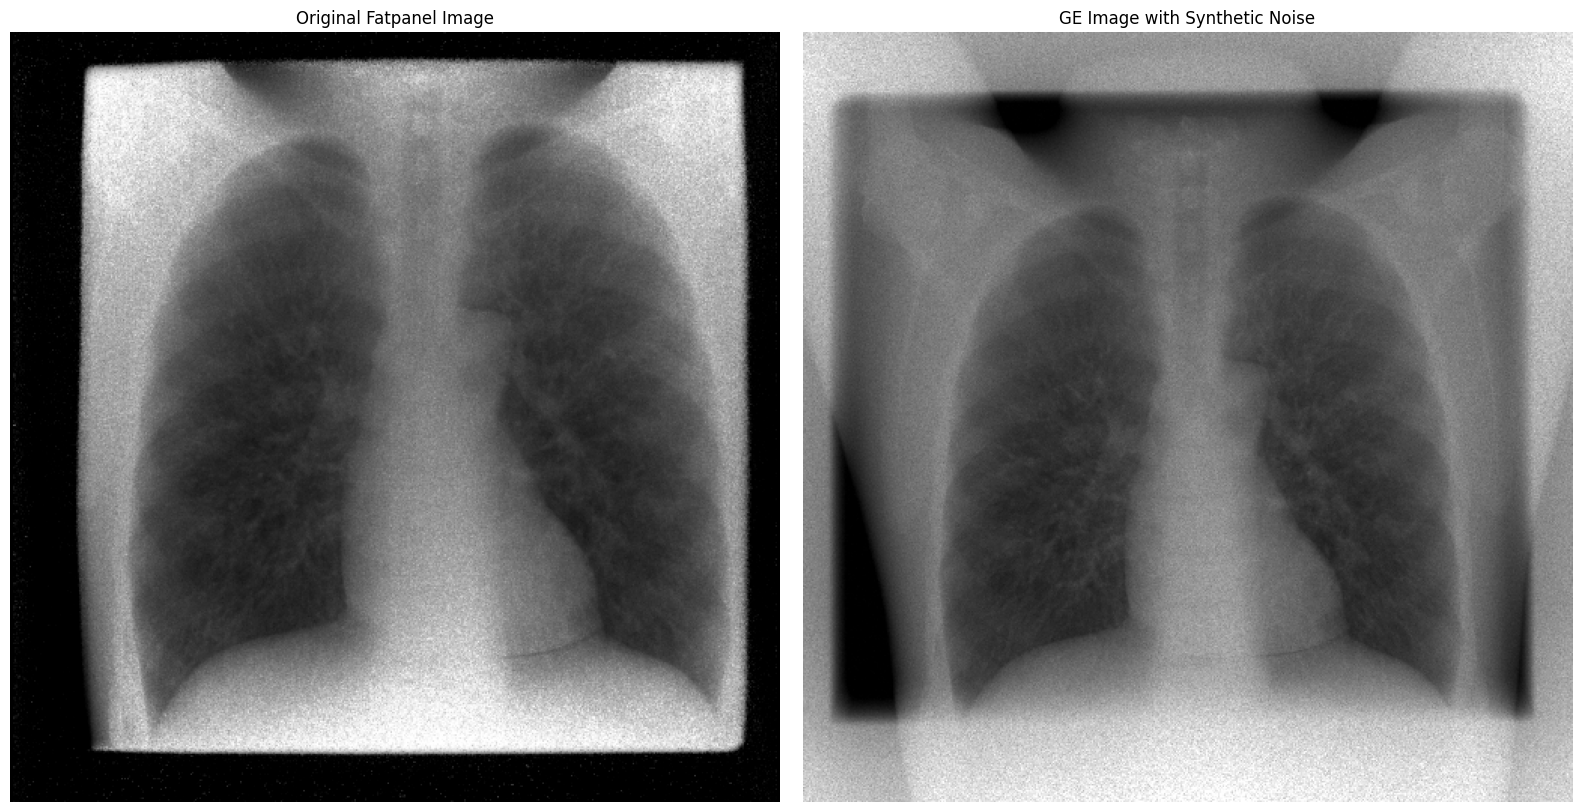

In [10]:
### GE vs fat comparison with noise, without blur
import os
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# Create output folder if not exists
os.makedirs("output", exist_ok=True)

# Load and preprocess GE image
ge_image = Image.open("input-512/ge-binned-log.png").convert("L")
to_tensor = transforms.ToTensor()
ge_tensor = to_tensor(ge_image).squeeze()  # shape (H, W)

# Assume poly_noise_std_module is your fitted torch.nn.Module that maps blurred mean -> noise std
# It expects input tensor (1,1,H,W)
ge_tensor_batch = ge_tensor.unsqueeze(0).unsqueeze(0)  # shape (1,1,H,W)

# Apply polynomial noise std to get noise std map
noise_std_map = POLY_NOISE_STD(ge_tensor_batch).squeeze()

# Generate noise tensor with per-pixel std
noisy_ge_tensor = torch.normal(ge_tensor, noise_std_map)

# Clamp to valid image range [0,1]
noisy_ge_tensor_clamped = torch.clamp(noisy_ge_tensor, 0.0, 1.0)

# Display side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(fat_tensor_full_size.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Fatpanel Image')
axs[0].axis('off')

axs[1].imshow(noisy_ge_tensor_clamped.cpu(), cmap='gray', vmin=0, vmax=1)
axs[1].set_title('GE Image with Synthetic Noise')
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Save images
fat_img_save = transforms.ToPILImage()(fat_tensor_full_size.cpu().squeeze())
fat_img_save.save("output/original_fatpanel.png")

noisy_ge_save = transforms.ToPILImage()(noisy_ge_tensor_clamped.cpu())
noisy_ge_save.save("output/ge_with_synthetic_noise.png")


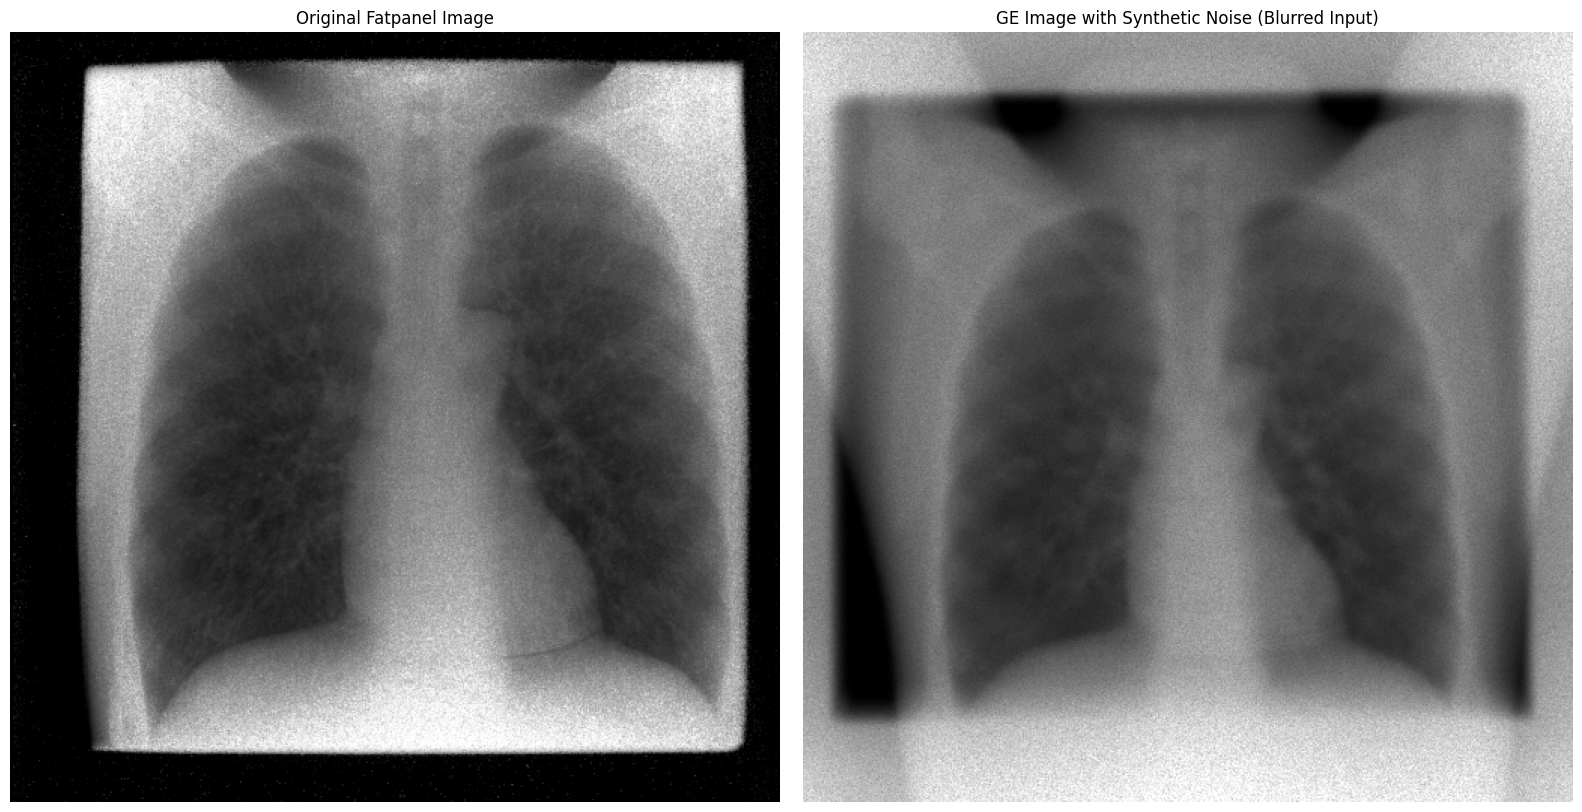

In [11]:
### GE vs fat comparison with noise, with blur
GE_BLUR_SIGMA = 2 # Standard deviation for Gaussian blur on GE image


from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch

# Create output folder if not exists
os.makedirs("output", exist_ok=True)

# Load and preprocess GE image
ge_image = Image.open("input-512/ge-binned-log.png").convert("L")
to_tensor = transforms.ToTensor()
ge_tensor = to_tensor(ge_image).squeeze(0)  # shape (H, W), remove channel dim

# Define GaussianBlur transform
sigma = GE_BLUR_SIGMA
kernel_size = int(6 * sigma + 1)
if kernel_size % 2 == 0:  # ensure kernel size is odd
    kernel_size += 1

gaussian_blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

# Apply blur (expects 3D tensor with channel, so add batch and channel dims)
ge_tensor_for_blur = ge_tensor.unsqueeze(0)  # (1, H, W)
ge_tensor_for_blur = ge_tensor_for_blur.unsqueeze(0)  # (1, 1, H, W)

blurred_ge = gaussian_blur(ge_tensor_for_blur).squeeze(0).squeeze(0)  # back to (H, W)

# Apply polynomial noise std module on blurred image
blurred_ge_batch = blurred_ge.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
noise_std_map = POLY_NOISE_STD(blurred_ge_batch).squeeze()  # (H, W)

# Generate noise with per-pixel std dev
noisy_ge_tensor = torch.normal(blurred_ge, noise_std_map)

# Clamp to valid image range
noisy_ge_tensor_clamped = torch.clamp(noisy_ge_tensor, 0.0, 1.0)

# Display side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(fat_tensor_full_size.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Fatpanel Image')
axs[0].axis('off')

axs[1].imshow(noisy_ge_tensor_clamped.cpu(), cmap='gray', vmin=0, vmax=1)
axs[1].set_title('GE Image with Synthetic Noise (Blurred Input)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Save images
fat_img_save = transforms.ToPILImage()(fat_tensor_full_size.cpu().squeeze())
fat_img_save.save("output/original_fatpanel.png")

noisy_ge_save = transforms.ToPILImage()(noisy_ge_tensor_clamped.cpu())
noisy_ge_save.save(f"output/ge_with_synthetic_noise_blur_sigma_{GE_BLUR_SIGMA}.png")

In [ ]:
### NIH vs fat comparison with noise, with blur
NIH_BLUR_SIGMA = 2.5 # Standard deviation for Gaussian blur on NIH image

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import os

# Create output folder if not exists
os.makedirs("output", exist_ok=True)

# Load and preprocess NIH image
nih_image = Image.open("input-512/NIH_2_0.png").convert("L")
to_tensor = transforms.ToTensor()
nih_tensor = to_tensor(nih_image).squeeze(0)  # shape (H, W), remove channel dim

nih_tensor = 0.8 * nih_tensor
nih_tensor = nih_tensor.clamp(0.02,1.0)

print(nih_tensor.max())

# Define GaussianBlur transform
sigma = NIH_BLUR_SIGMA
kernel_size = int(6 * sigma + 1)
if kernel_size % 2 == 0:  # ensure kernel size is odd
    kernel_size += 1

gaussian_blur = transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

# Apply blur (expects 3D tensor with channel, so add batch and channel dims)
nih_tensor_for_blur = nih_tensor.unsqueeze(0)  # (1, H, W)
nih_tensor_for_blur = nih_tensor_for_blur.unsqueeze(0)  # (1, 1, H, W)

blurred_nih = gaussian_blur(nih_tensor_for_blur).squeeze(0).squeeze(0)  # back to (H, W)

# Apply polynomial noise std module on blurred image
blurred_nih_batch = blurred_nih.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
noise_std_map = POLY_NOISE_STD(blurred_nih_batch).squeeze()  # (H, W)

# Generate noise with per-pixel std dev
noisy_nih_tensor = torch.normal(blurred_nih, noise_std_map)


print(noisy_nih_tensor.max())

# Clamp to valid image range
noisy_nih_tensor_clamped = torch.clamp(noisy_nih_tensor, 0.0, 1.0)

# Display side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(fat_tensor_full_size.cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Fatpanel Image')
axs[0].axis('off')

axs[1].imshow(noisy_nih_tensor_clamped.cpu(), cmap='gray', vmin=0, vmax=1)
axs[1].set_title('NIH Image with Synthetic Noise (Blurred Input)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

print(noisy_nih_tensor_clamped.max())

# Save images
fat_img_save = transforms.ToPILImage()(fat_tensor_full_size.cpu().squeeze())
fat_img_save.save("output/original_fatpanel.png")

noisy_nih_save = transforms.ToPILImage()(noisy_nih_tensor_clamped.cpu())
noisy_nih_save.save(f"output/NIH_noise_blur_{NIH_BLUR_SIGMA}.png")

tensor(0.7875)
tensor(0.9005)


tensor(0.9005)


# Notes and thoughts
- The increased noise further from the center seems to be from a total lack of signal - Denoising would be worthless. This is not a problem since (A) the lungs are the element of interest and (B) the edge noise is in large part due to the chosen camera, and could be improved with future iterations of the fatpanel.

# The method
NIH -> [0.02, 0.8] (this is Y) -> Blur (sigma=3) -> Noise (std signal dependent*) -> clamp [0, 1] -> X



